In [1]:
import sys
sys.path.append('../')

In [2]:
import os

import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

import blo.params as blo_params
from blo.utils import load_problem, factory_get_path

In [3]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.reload_library()
plt.style.use(['science'])

In [14]:
def get_solver_results(param_vals, data_dir):
    """ Get results for the solver. """
    solver_result_dir = 'solver_results'
    solver_result_dir = f'{data_dir}{solver_result_dir}/'

    solver_result_files = os.listdir(solver_result_dir)
    solver_result_files = list(filter(lambda x: "raw_res" not in x, solver_result_files))

    print("Number of files:", len(solver_result_files))
    solver_results = {}
    
    for v in param_vals['v']:
        solver_results[v] = {}

        for gamma in param_vals['gamma']:
            solver_results[v][gamma] = {}

            for eta in param_vals['eta']:
                solver_results[v][gamma][eta] = {}
            
                for d_ratio in param_vals['d_ratio']:
                    solver_results[v][gamma][eta][d_ratio] = {}
                    
                    for a_ratio in param_vals['a_ratio']:
                        solver_results[v][gamma][eta][d_ratio][a_ratio] = []

                        for i in param_vals['inst_ids']:
                            inst_str = f"v-{v}_"
                            inst_str += f"g-{gamma}_"
                            inst_str += f"ep-{param_vals['epsilon_ratio']}_"
                            inst_str += f"de-{param_vals['delta_ratio']}_"
                            inst_str += f"dr-{d_ratio}_"
                            inst_str += f"ar-{a_ratio}__"
                            inst_str += f"i-{i}"

                            try:
               
                                f = list(filter(lambda x: inst_str in x, solver_result_files))[0]
                                f = solver_result_dir + f
    
                                with open(f, 'rb') as p:
                                    d = pkl.load(p)
                                    d['leader_obj'] = - d['leader_obj'] # fix for negative value
                                    solver_results[v][gamma][eta][d_ratio][a_ratio].append(d)

                            except:
                                res = {
                                    'time' : np.nan,
                                    'leader_obj': np.nan,
                                    'follower_obj': np.nan,
                                    'x': np.nan,
                                    'y': np.nan,
                                    'inc_objs':np.nan,
                                    'inc_times': np.nan,
                                    'blo_solve_res': {
                                        'leader_obj':np.nan,
                                        'follower_obj': np.nan,
                                        'leader_sol': np.nan,
                                        'follower_sol': np.nan,
                                    }
                                }
                
                                solver_results[v][gamma][eta][d_ratio][a_ratio].append(res)                                  
    return solver_results

In [15]:
def get_results(param_vals, data_dir, model_type, vf_constr_type, approx_type):
    """ Get results for ml algorithm. """
    result_dir = 'results'
    result_dir = f'{data_dir}{result_dir}/'

    result_files = os.listdir(result_dir)
    result_files = list(filter(lambda x: f"m-{model_type}" in x, result_files))
    result_files = list(filter(lambda x: f"v-{vf_constr_type}" in x, result_files))
    result_files = list(filter(lambda x: f"a-{approx_type}" in x, result_files))

    print("Number of files:", len(result_files))

    results = {}

    for v in param_vals['v']:
        results[v] = {}

        for gamma in param_vals['gamma']:
            results[v][gamma] = {}

            for eta in param_vals['eta']:
                results[v][gamma][eta] = {}
            
                for d_ratio in param_vals['d_ratio']:
                    results[v][gamma][eta][d_ratio] = {}
                    
                    for a_ratio in param_vals['a_ratio']:
                        results[v][gamma][eta][d_ratio][a_ratio] = []

                        for i in param_vals['inst_ids']:
                            inst_str = f"v-{v}_"
                            inst_str += f"g-{gamma}_"
                            inst_str += f"ep-{param_vals['epsilon_ratio']}_"
                            inst_str += f"de-{param_vals['delta_ratio']}_"
                            inst_str += f"dr-{d_ratio}_"
                            inst_str += f"ar-{a_ratio}__"
                            inst_str += f"i-{i}"

                            try:
               
                                f = list(filter(lambda x: inst_str in x, result_files))[0]
                                f = result_dir + f
    
                                # print(f)
                                with open(f, 'rb') as p:
                                    results[v][gamma][eta][d_ratio][a_ratio].append(pkl.load(p))

                            except:
                                res = {
                                    'time' : np.nan,
                                    'leader_obj': np.nan,
                                    'follower_obj': np.nan,
                                    'x': np.nan,
                                    'y': np.nan,
                                    'inc_objs':np.nan,
                                    'inc_times': np.nan,
                                    'blo_solve_res': {
                                        'leader_obj':np.nan,
                                        'follower_obj': np.nan,
                                        'leader_sol': np.nan,
                                        'follower_sol': np.nan,
                                    }
                                }
                
                                results[v][gamma][eta][d_ratio][a_ratio].append(res)      
    
    return results


In [16]:
def get_time_to_obj(algo_obj, algo_time, solver_result, as_ratio=True):
    """ Gets time to a given objective. """
    inc_objs = solver_result['inc_objs']
    inc_times = solver_result['inc_times']
    
    if np.isnan(solver_result['leader_obj']):
        return np.nan

    # iterate over incumbents
    time_to_obj = None
    for i in range(len(inc_objs)):
        if (- inc_objs[i] - algo_obj)/algo_obj >= -1e-3:
            time_to_obj = inc_times[i]
            break

    # check the final objective
    if time_to_obj is None:
        # assert(solver_result['obj'] <= obj + 1e-5)
        if solver_result['leader_obj'] >= algo_obj - 1e-5:
            time_to_obj = solver_result['time']
        else:
            time_to_obj = np.nan

    if as_ratio:
        time_to_obj = time_to_obj / algo_time

    return time_to_obj

In [17]:
def get_obj_at_ml_time(algo_obj, algo_time, solver_result, as_re=True):
    """ Gets objective at time of given algorithm. """
    inc_objs = solver_result['inc_objs']
    inc_times = solver_result['inc_times']
            
    if np.isnan(solver_result['leader_obj']):
        return np.nan

    if solver_result['time'] < algo_time:
        return solver_result['leader_obj']
    
    # iterate over incumbents
    best_inc = np.nan
    for i in range(len(inc_objs)):
        if inc_times[i] <= algo_time:
            best_inc =  - inc_objs[i]

    # compute relative err
    if as_re:
        best_obj = np.max([best_inc, algo_obj])
        relative_err = 100 * (best_obj - best_inc ) / best_obj
        return relative_err

    return best_inc

In [18]:
def get_time_to_str(algo_time_to, precision=2):
    """ Get time to for latex tables.  """
    algo_worse = len(algo_time_to) - np.count_nonzero(np.isnan(algo_time_to))
    if algo_worse == 0:
        algo_mean_tt = np.nan
    else:
        algo_mean_tt = round(np.nanmean(algo_time_to), precision)

    algo_str = f"{algo_mean_tt}  ({algo_worse})"

    return algo_str

In [19]:
model_type = "inst_encoder"

param_vals = {
    'v' : [10, 25, 50, 100, 300, 500],
    'gamma' : [0.0, 0.1],
    'eta' : [0.60], 
    'epsilon_ratio' : 1.25,
    'delta_ratio' : 0.80,
    'd_ratio' : [0.30, 0.75],
    'a_ratio' : [0.03, 0.10, 0.30],
    'inst_ids' : list(range(1,26)),
}

In [20]:
problem = 'cng'
# dataset = 'jan_28_cng_ml'
# # dataset = 'jan_29_cng_fixed_upper'
# dataset = 'jan_29_cng_fixed_upper_and_solver'

In [21]:
# data_dir = f'../../datasets/{dataset}/{problem}/'
data_dir = f'../data/{problem}/'

In [23]:
solver_results = get_solver_results(param_vals, data_dir)

Number of files: 1797


In [24]:
nn_lower_results = get_results(param_vals, data_dir, model_type, "slack", "lower")

Number of files: 1800


In [25]:
nn_upper_results = get_results(param_vals, data_dir, model_type, "none", "upper")

Number of files: 1800


# Main Paper Results

In [26]:
# columns for table
cols = [
        'nn_l_mre',  'nn_u_mre',  's_mre',
        'nn_l_time', 'nn_u_time',  's_time', 
       ]

In [27]:
# indicies for table
indicies = []

for v in param_vals['v']:
    id = v
    indicies.append(id)

avg = "Average"
indicies.append(avg)

In [28]:
# aggregate results
epsilon_ratio = param_vals['epsilon_ratio']
delta_ratio = param_vals['delta_ratio']

solver_results_by_size = {}
nn_lower_results_by_size = {}
nn_upper_results_by_size = {}

for v in param_vals['v']:
    solver_results_by_size[v] = []
    nn_lower_results_by_size[v] = []
    nn_upper_results_by_size[v] = []
    for gamma in param_vals['gamma']:
        for eta in param_vals['eta']:
            for d_ratio in param_vals['d_ratio']:
                for a_ratio in param_vals['a_ratio']:

                    # get results 
                    solver_res = solver_results[v][gamma][eta][d_ratio][a_ratio]
                    nn_lower_res = nn_lower_results[v][gamma][eta][d_ratio][a_ratio]
                    nn_upper_res = nn_upper_results[v][gamma][eta][d_ratio][a_ratio]

                    solver_results_by_size[v] += solver_res
                    nn_lower_results_by_size[v] += nn_lower_res
                    nn_upper_results_by_size[v] += nn_upper_res

In [29]:
# more in depth gap storing
relative_errors = {
    'nn_l' : {},
    'nn_u' : {},
    'exact' : {},
}

for v in param_vals['v']:
    relative_errors['nn_l'][v] = []
    relative_errors['nn_u'][v] = []
    relative_errors['exact'][v] = []

In [30]:
df = pd.DataFrame(index=indicies, columns=cols)

In [31]:
for v in param_vals['v']:
    
    # results for solver at n, k
    solver_res = solver_results_by_size[v]
    solver_times = np.nanmean(list(map(lambda x: x['time'], solver_res)))
    solver_objs = list(map(lambda x: x['leader_obj'], solver_res))
        
    # results for ml slack at n,k
    nn_lower_res = nn_lower_results_by_size[v]
    nn_lower_times = list(map(lambda x: x['time'], nn_lower_res))
    nn_lower_objs = list(map(lambda x: x['leader_obj'], nn_lower_res))
    
    # results for ml upper (i.e., no constraint adjustment) at n,k
    nn_upper_res = nn_upper_results_by_size[v]
    nn_upper_times = list(map(lambda x: x['time'], nn_upper_res))
    nn_upper_objs = list(map(lambda x: x['leader_obj'], nn_upper_res))
    
    # best best known obj for each instance
    objs = np.array([solver_objs, nn_lower_objs, nn_upper_objs])
    best_objs = list(np.nanmax(objs, axis=0))
    
    # compute relative errors
    solver_re = list(map(lambda x, y: 100 * (y-x)/x, solver_objs, best_objs)) 
    nn_lower_re = list(map(lambda x, y: 100 * (y-x)/x, nn_lower_objs, best_objs)) 
    nn_upper_re = list(map(lambda x, y: 100 * (y-x)/x, nn_upper_objs, best_objs)) 

    # set values in dataframe
    id = v
    
    df['nn_l_mre'][id] = np.mean(nn_lower_re)
    df['nn_u_mre'][id] = np.mean(nn_upper_re)
    df['s_mre'][id] = np.nanmean(solver_re)

    df['nn_l_time'][id] = np.mean(nn_lower_times)
    df['nn_u_time'][id] = np.mean(nn_upper_times)
    df['s_time'][id] = np.nanmean(solver_times)
    
    relative_errors['nn_l'][v] += nn_lower_re
    relative_errors['nn_u'][v] += nn_upper_re
    relative_errors['exact'][v] += solver_re


In [32]:
df['nn_l_mre'][avg] = np.mean(df['nn_l_mre'])
df['nn_u_mre'][avg] = np.mean(df['nn_u_mre'])
df['s_mre'][avg] = np.mean(df['s_mre'])

df['nn_l_time'][avg] = np.mean(df['nn_l_time'])
df['nn_u_time'][avg] = np.mean(df['nn_u_time'])
df['s_time'][avg] = np.mean(df['s_time'])

In [34]:
def latex_results_agg(df_):
    """ Generate Latex table for results.  """

    df = df_.copy()

    col_order = [
        'nn_l_mre', 'nn_l_time',
        'nn_u_mre', 'nn_u_time', 
        's_mre', 's_time',
    ]

    df = df[col_order]
    
    
    df = df.rename(columns={
        'nn_l_mre' : 'MRE',
        'nn_u_mre' : 'MRE\ ',
        's_mre'    : 'MRE\ \ ',

        'nn_l_time' : 'Time',
        'nn_u_time' : 'Time\ ',
        's_time'    : 'Time\ \ ',
    })

        
    df = df.style.format(thousands=',', precision=2)        

    # bold minimum value in table
    df = df.highlight_min(subset=['MRE',  'MRE\ ',  'MRE\ \ '], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['Time', 'Time\ ', 'Time\ \ '], props='textbf:--rwrap;', axis=1)

    # caption
    end_str = '}\n\\caption{Critical Node Game Results:'
    end_str += 'Each row averaged over 300 instances.  ' 
    end_str += '\\mls{} and \\mlu{} specify the lower- and upper-level approximations respectively.  '
    end_str += 'All times in seconds.  }\n'
    end_str += '\\label{tab:cng_results}\n'
    end_str += '\\end{table*}' 

    latex_str = df.to_latex(column_format='cc|rr|rr|rr|rr').replace('_','\_').replace('nan', '-').replace('#', '\#')

    row_id = "$|V|$"
    
    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(2, row_id + ' & \multicolumn{2}{c|}{\\mls}  & \multicolumn{2}{c|}{\\mlu} & \multicolumn{2}{c}{\\solver} \\\\')
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{0.5\\textwidth}{!}{')
    latex_str2[-1] += end_str

    print("\n".join(latex_str2))
    print()

In [35]:
latex_results_agg(df)

\begin{table*}[h]\centering\resizebox{0.5\textwidth}{!}{
\begin{tabular}{cc|rr|rr|rr|rr}
\toprule
$|V|$ & \multicolumn{2}{c|}{\mls}  & \multicolumn{2}{c|}{\mlu} & \multicolumn{2}{c}{\solver} \\
 & MRE & Time & MRE\  & Time\  & MRE\ \  & Time\ \  \\
\midrule
10 & 3.20 & 0.04 & 2.75 & \textbf{0.02} & \textbf{1.01} & 4.24 \\
25 & 2.60 & 0.23 & 1.77 & \textbf{0.05} & \textbf{0.73} & 3,244.20 \\
50 & 1.42 & 0.38 & 0.98 & \textbf{0.10} & \textbf{0.67} & 3,600.30 \\
100 & 1.12 & 0.48 & \textbf{0.56} & \textbf{0.42} & 1.79 & 3,600.65 \\
300 & 2.01 & 1.12 & \textbf{0.33} & \textbf{0.83} & 2.32 & 3,600.54 \\
500 & 1.33 & 1.69 & \textbf{0.45} & \textbf{1.19} & 2.47 & 3,600.80 \\
Average & 1.95 & 0.66 & \textbf{1.14} & \textbf{0.43} & 1.50 & 2,941.79 \\
\bottomrule
\end{tabular}}
\caption{Critical Node Game Results:Each row averaged over 300 instances.  \mls{} and \mlu{} specify the lower- and upper-level approximations respectively.  All times in seconds.  }
\label{tab:cng_results}
\end{table*}



# Appendix Obj Results

In [36]:
# columns for table
cols = ['nn_l_obj', 'nn_u_obj',  's_obj',
        'nn_l_mre',  'nn_u_mre',  's_mre',
        'nn_l_time', 'nn_u_time',  's_time', 
        'nn_l_to',  'nn_u_to', 
        'nn_l_at',  'nn_u_at',
       ]

In [37]:
# indicies for table
indicies = []

for v in param_vals['v']:
    id = v
    indicies.append(id)

In [38]:
# aggregate results
epsilon_ratio = param_vals['epsilon_ratio']
delta_ratio = param_vals['delta_ratio']

solver_results_by_size = {}
nn_lower_results_by_size = {}
nn_upper_results_by_size = {}

for v in param_vals['v']:
    solver_results_by_size[v] = []
    nn_lower_results_by_size[v] = []
    nn_upper_results_by_size[v] = []
    for gamma in param_vals['gamma']:
        for eta in param_vals['eta']:
            for d_ratio in param_vals['d_ratio']:
                for a_ratio in param_vals['a_ratio']:

                    # get results 
                    solver_res = solver_results[v][gamma][eta][d_ratio][a_ratio]
                    nn_lower_res = nn_lower_results[v][gamma][eta][d_ratio][a_ratio]
                    nn_upper_res = nn_upper_results[v][gamma][eta][d_ratio][a_ratio]

                    solver_results_by_size[v] += solver_res
                    nn_lower_results_by_size[v] += nn_lower_res
                    nn_upper_results_by_size[v] += nn_upper_res

In [39]:
# more in depth gap storing
relative_errors = {
    'nn_l' : {},
    'nn_u' : {},
    'exact' : {},
}

for v in param_vals['v']:
    relative_errors['nn_l'][v] = []
    relative_errors['nn_u'][v] = []
    relative_errors['exact'][v] = []

In [40]:
df = pd.DataFrame(index=indicies, columns=cols)

In [41]:
for v in param_vals['v']:
    
    # results for solver at n, k
    solver_res = solver_results_by_size[v]
    solver_times = np.nanmean(list(map(lambda x: x['time'], solver_res)))
    solver_objs = list(map(lambda x: x['leader_obj'], solver_res))
        
    # results for ml slack at n,k
    nn_lower_res = nn_lower_results_by_size[v]
    nn_lower_times = list(map(lambda x: x['time'], nn_lower_res))
    nn_lower_objs = list(map(lambda x: x['leader_obj'], nn_lower_res))
    
    # results for ml upper (i.e., no constraint adjustment) at n,k
    nn_upper_res = nn_upper_results_by_size[v]
    nn_upper_times = list(map(lambda x: x['time'], nn_upper_res))
    nn_upper_objs = list(map(lambda x: x['leader_obj'], nn_upper_res))
    
    # best best known obj for each instance
    objs = np.array([solver_objs, nn_lower_objs, nn_upper_objs])
    best_objs = list(np.nanmax(objs, axis=0))
    
    # compute relative errors
    solver_re = list(map(lambda x, y: 100 * (y-x)/x, solver_objs, best_objs)) 
    nn_lower_re = list(map(lambda x, y: 100 * (y-x)/x, nn_lower_objs, best_objs)) 
    nn_upper_re = list(map(lambda x, y: 100 * (y-x)/x, nn_upper_objs, best_objs)) 

    # get time to results
    as_ratio = True
    nn_lower_time_to = list(map(lambda x, y, z: get_time_to_obj(x, y, z, as_ratio=as_ratio), nn_lower_objs, nn_lower_times, solver_res))
    nn_upper_time_to = list(map(lambda x, y, z: get_time_to_obj(x, y, z, as_ratio=as_ratio), nn_upper_objs, nn_upper_times, solver_res))

    # get obj at time
    as_re= True
    solver_at_nn_lower_time = list(map(lambda x, y, z: get_obj_at_ml_time(x, y, z, as_re=as_re), nn_lower_objs, nn_lower_times, solver_res))
    solver_at_nn_upper_time = list(map(lambda x, y, z: get_obj_at_ml_time(x, y, z, as_re=as_re), nn_upper_objs, nn_upper_times, solver_res))

    # set values in dataframe
    id = v
    
    df['nn_l_obj'][id] = np.mean(nn_lower_objs)
    df['nn_u_obj'][id] = np.mean(nn_upper_objs)
    df['s_obj'][id] = np.nanmean(solver_objs)
    
    df['nn_l_mre'][id] = np.mean(nn_lower_re)
    df['nn_u_mre'][id] = np.mean(nn_upper_re)
    df['s_mre'][id] = np.nanmean(solver_re)

    df['nn_l_time'][id] = np.mean(nn_lower_times)
    df['nn_u_time'][id] = np.mean(nn_upper_times)
    df['s_time'][id] = np.nanmean(solver_times)

    df['nn_l_to'][id] = get_time_to_str(nn_lower_time_to)
    df['nn_u_to'][id] = get_time_to_str(nn_upper_time_to)
    
    df['nn_l_at'][id] = get_time_to_str(solver_at_nn_lower_time)
    df['nn_u_at'][id] = get_time_to_str(solver_at_nn_upper_time)
    
    relative_errors['nn_l'][v] += nn_lower_re
    relative_errors['nn_u'][v] += nn_upper_re
    relative_errors['exact'][v] += solver_re


In [44]:
def latex_results_agg(df_):
    """ Generate Latex table for results.  """

    df = df_.copy()

    df = df.rename(columns={
        'nn_l_obj' : '\\mls',
        'nn_u_obj' : '\\mlu',
        's_obj' : '\\solver',
 
        'nn_l_mre' : '\\mls\ ',
        'nn_u_mre' : '\\mlu\ ',
        's_mre' : '\\solver\ ',

        'nn_l_time' : '\\mls\ \ ',
        'nn_u_time' : '\\mlu\ \ ',
        's_time' : '\\solver\ \ ',

        'nn_l_to' : '\\mls\ \ \ ',
        'nn_u_to' : '\\mlu\ \ \ ',

        'nn_l_at' : '\\mls\ \ \ \ ',
        'nn_u_at' : '\\mlu\ \ \ \ ',
    })

    df = df.style.format(thousands=',', precision=2)        
    
    # bold minimum value in table
    df = df.highlight_max(subset=['\\mls',     '\\mlu',     '\\solver'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['\\mls\ ',   '\\mlu\ ',   '\\solver\ '], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['\\mls\ \ ', '\\mlu\ \ ', '\\solver\ \ '], props='textbf:--rwrap;', axis=1)

    # caption
    end_str = '}\n\\caption{Critical Node Game Results:'
    end_str += 'Each row averaged over 300 instances.  ' 
    end_str += '\\mls{} and \\mlu{} specify the lower- and upper-level approximations respectively.  '
    end_str += 'All times in seconds.  }\n'
    end_str += '\\label{tab:cng_results}\n'
    end_str += '\\end{table*}' 

    latex_str = df.to_latex(column_format='l|rrr|rrr|rrr|rr|rr').replace('_','\_').replace('nan', '-').replace('#', '\#')

    row_id = "$|V|$"
    
    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(2, row_id + ' & \multicolumn{3}{c|}{Objective}  &  \multicolumn{3}{c|}{Mean Relative Error (\%)}  & \multicolumn{3}{c|}{Times} & \multicolumn{2}{c|}{Solver Time Ratio} & \multicolumn{2}{c}{Solver Relative Error at Time} \\\\')
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{0.8\\textwidth}{!}{')
    latex_str2[-1] += end_str

    print("\n".join(latex_str2))
    print()

In [45]:
latex_results_agg(df)

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rrr|rrr|rrr|rr|rr}
\toprule
$|V|$ & \multicolumn{3}{c|}{Objective}  &  \multicolumn{3}{c|}{Mean Relative Error (\%)}  & \multicolumn{3}{c|}{Times} & \multicolumn{2}{c|}{Solver Time Ratio} & \multicolumn{2}{c}{Solver Relative Error at Time} \\
 & \mls & \mlu & \solver & \mls\  & \mlu\  & \solver\  & \mls\ \  & \mlu\ \  & \solver\ \  & \mls\ \ \  & \mlu\ \ \  & \mls\ \ \ \  & \mlu\ \ \ \  \\
\midrule
10 & 224.47 & 225.10 & \textbf{228.63} & 3.20 & 2.75 & \textbf{1.01} & 0.04 & \textbf{0.02} & 4.24 & 51.23  (288) & 105.82  (289) & 3.45  (184) & 1.76  (131) \\
25 & 562.72 & 566.23 & \textbf{572.51} & 2.60 & 1.77 & \textbf{0.73} & 0.23 & \textbf{0.05} & 3,244.20 & 7664.71  (275) & 24069.9  (270) & 2.38  (251) & 2.84  (115) \\
50 & 1,139.27 & 1,143.95 & \textbf{1,148.17} & 1.42 & 0.98 & \textbf{0.67} & 0.38 & \textbf{0.10} & 3,600.30 & 3892.14  (221) & 15380.5  (178) & 1.98  (295) & 3.26  (186) \\
100 & 2,285.15 & \te

# Appendix: Box Plots

In [46]:
relative_errors['nn_l'] = list(relative_errors['nn_l'].values())
relative_errors['nn_u'] = list(relative_errors['nn_u'].values())
relative_errors['exact'] = list(relative_errors['exact'].values())

In [47]:
for i in range(len(relative_errors['exact'])):
    re = relative_errors['exact'][i]

    if np.sum(np.isnan(re)) > 0:
        print(f"index {i} has {np.sum(np.isnan(re))} nans, ramoving")
        re = [x for x in re if not np.isnan(x)]
        relative_errors['exact'][i] = re

index 5 has 2 nans, ramoving


In [48]:
colors = ['#8DDFCB', '#82A0D8', '#EDB7ED']

In [49]:
# combine data
data_groups = [relative_errors['nn_l'], relative_errors['nn_u'], relative_errors['exact']]

In [50]:
# labels
labels = param_vals['v']

In [51]:
# widths
width       = 1/len(labels)
xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(data_groups[0])) ]

ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])

In [52]:
fontsize = 20

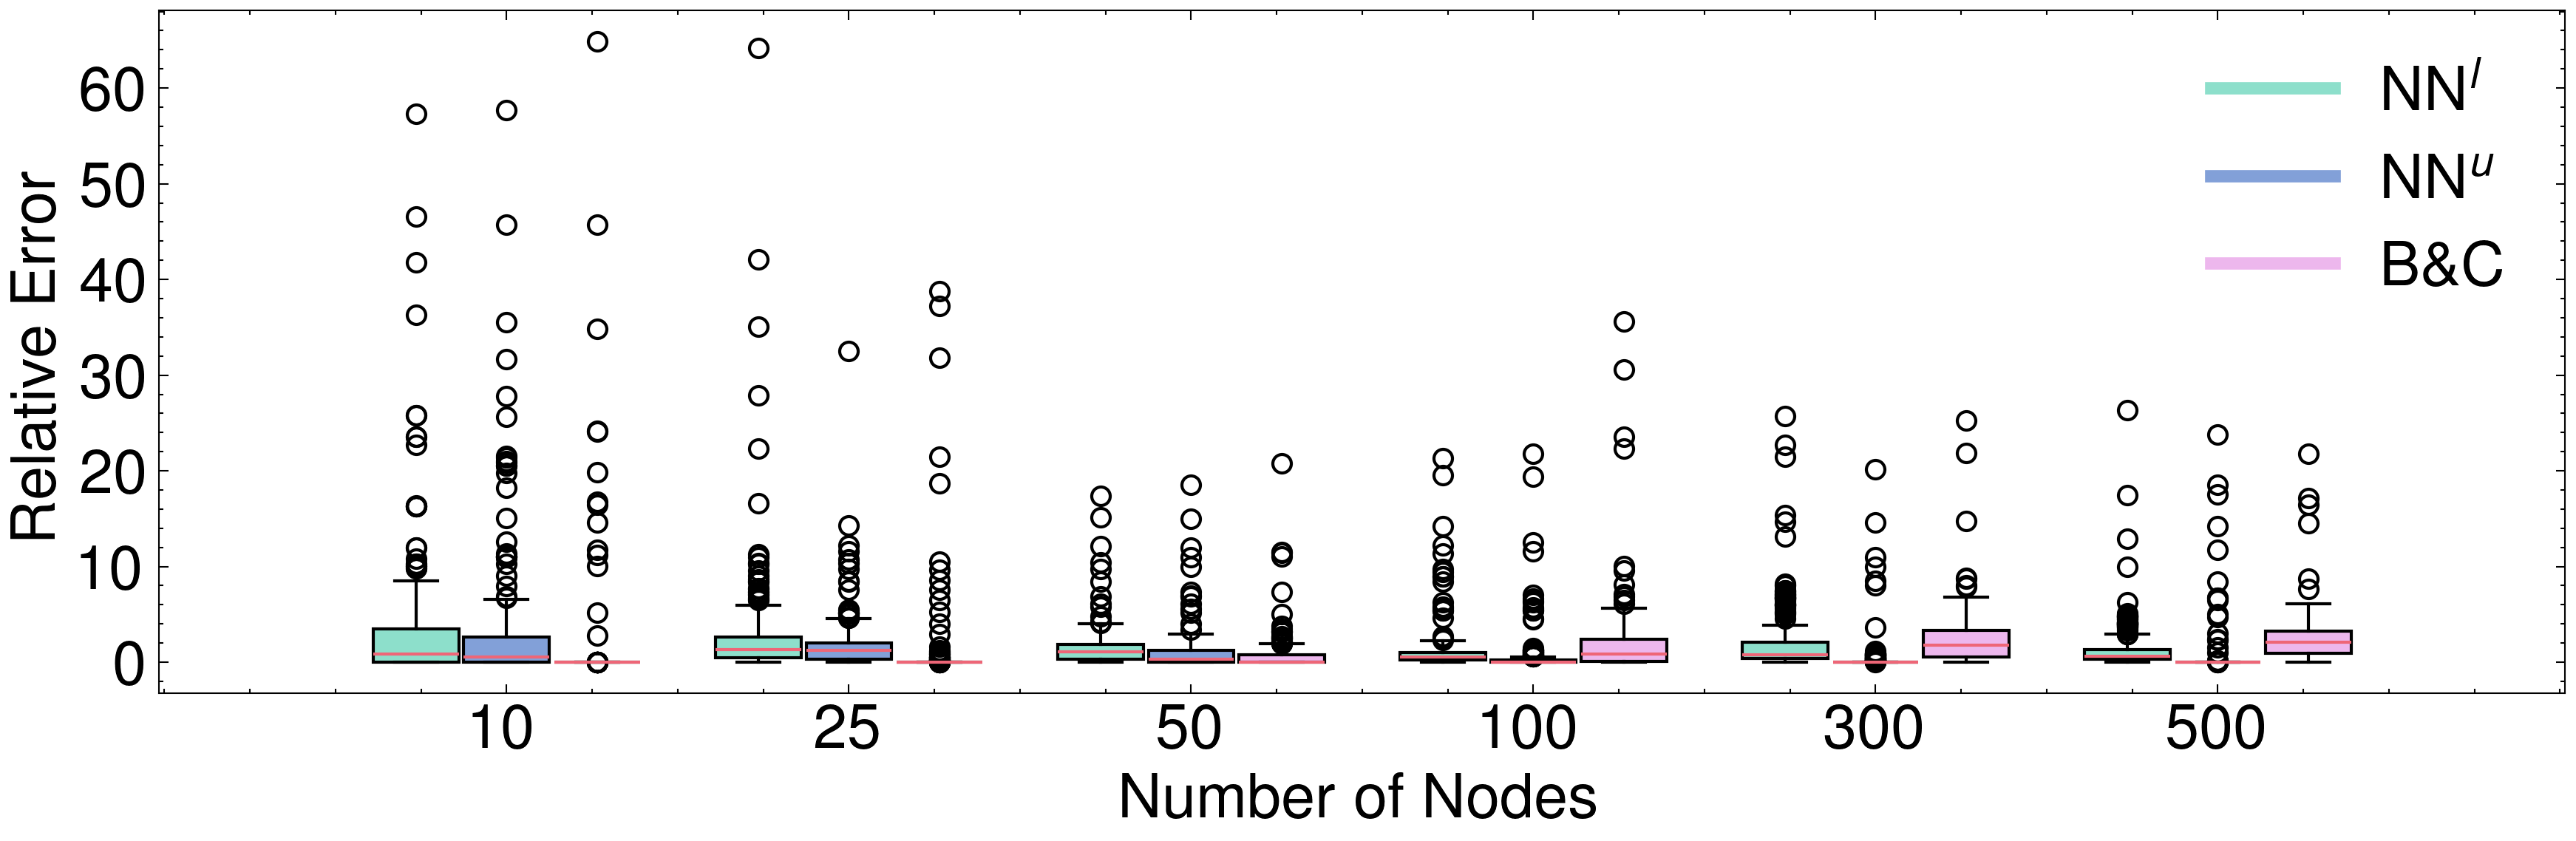

In [53]:
with plt.style.context(['science', 'nature', 'bright']):

    fig, ax = plt.subplots(figsize=(14,4), dpi=300)

    ax = plt.gca()

    space = len(data_groups)/2
    offset = len(data_groups)/2

    # --- Offset the positions per group:

    group_positions = []
    for num, dg in enumerate(data_groups):    
        _off = (0 - space + (0.5+num))
        group_positions.append([x+_off*(width+0.01) for x in xlocations])

    for dg, pos, c in zip(data_groups, group_positions, colors):
        boxes = ax.boxplot(dg, 
                    labels=['']*len(labels),
                    positions=pos, 
                    widths=width, 
                    boxprops=dict(facecolor=c),                    
                    patch_artist=True)

    # legends
    custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                    Line2D([0], [0], color=colors[1], lw=4),
                    Line2D([0], [0], color=colors[2], lw=4),]
    
    ax.legend(custom_lines,['NN$^l$', 'NN$^u$', 'B\&C'], fontsize=fontsize)

    #plt.axhline(y=0.0, color='lightgrey', linestyle='-')

    ax.set_xticks(xlocations)#, fontsize=fontsize)
    ax.set_xticklabels(labels, rotation=0)

    ax.set_ylabel('Relative Error', fontsize=fontsize)
    ax.set_xlabel('Number of Nodes', fontsize=fontsize)

    plt.yticks(fontsize=fontsize)  
    plt.xticks(fontsize=fontsize)    

    plt.savefig("figs/bp_cng.pdf")
    
    plt.show()

# Data Collection + Training Time

In [54]:
class A():
    pass

In [55]:
args = A()
args.v = v
model_type = "inst_encoder"

In [56]:
ml_times = {}
u_tr_times = {}
l_tr_times = {}

for v in param_vals['v']:

    args.problem = f"cng_{v}"
    get_path = factory_get_path(args)
    cfg = getattr(blo_params, args.problem)
    cfg.data_path = f'../data/'

    # load dataset
    fp_data = get_path(cfg.data_path, cfg, "ml_data")
 
    with open(fp_data, 'rb') as pf:
        ml_dataset = pkl.load(pf)

    ml_times[v] = ml_dataset['total_time']
   
    for approx_type in ["lower", "upper"]:
        
        fp_nn_res = get_path(cfg.data_path, cfg, f"nn_res_{model_type}_{approx_type}", suffix="pkl")

        with open(fp_nn_res, 'rb') as pf:
           nn_res = pkl.load(pf)

        if approx_type == "lower":
            l_tr_times[v] = nn_res['train_time']
        else:
            u_tr_times[v] = nn_res['train_time']
 

In [57]:
u_tr_times

{10: 4670.8773872852325,
 25: 4841.317259788513,
 50: 2963.6485726833344,
 100: 2931.4317667484283,
 300: 3598.0494508743286,
 500: 6214.358114957809}

In [58]:
l_tr_times

{10: 1839.6055123806,
 25: 2072.608265399933,
 50: 2103.500406742096,
 100: 1944.0827460289001,
 300: 3800.0235810279846,
 500: 2263.6821324825287}

In [59]:
u_tr_times

{10: 4670.8773872852325,
 25: 4841.317259788513,
 50: 2963.6485726833344,
 100: 2931.4317667484283,
 300: 3598.0494508743286,
 500: 6214.358114957809}